In [22]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_model
from adaptive_filter.cerebellum import AdaptiveFilterCerebellum
from cmac import CMAC

from tqdm import tqdm  # progress bar

In [38]:
angles_diff = np.array([[0, 0]])
inp = np.array([[0, 0, 0, 0]])
abs_px = np.array([[0, 0, 0, 0]])

datasets = ["data/training_data.p"]
for i in range(2, 32):
    datasets.append("data/training_data"+str(i)+".p")

for dataset in datasets:
    print("Processing {}".format(dataset))
    # Load data
    data = pickle.load(open(dataset, "rb"))
    angles = data[:, :2]
    angles /= 90.0
    end_pos = data[:, 2:]
    end_pos = (end_pos - 200) / 200

    for i, angle in tqdm(enumerate(angles)):
        for j, angle2 in enumerate(angles):
            if i!=j:
                angles_diff = np.concatenate((angles_diff, [angle2]))
                inp = np.concatenate((inp, [np.concatenate((end_pos[j] - end_pos[i], angle))]))
                abs_px = np.concatenate((abs_px, [np.concatenate((end_pos[i], end_pos[j]))]))
with open('processed_abs.p', 'wb') as file:
    pickle.dump((inp, angles_diff, abs_px), file)
# with open('processed_abs.p', 'rb') as file:
#     inp, angles_diff = pickle.load(file)

Processing data/training_data.p


100it [00:00, 166.46it/s]


Processing data/training_data2.p


100it [00:00, 107.03it/s]


Processing data/training_data3.p


100it [00:02, 49.68it/s]


Processing data/training_data4.p


100it [00:03, 31.63it/s]


Processing data/training_data5.p


100it [00:03, 25.84it/s]


Processing data/training_data6.p


100it [00:04, 20.89it/s]


Processing data/training_data7.p


100it [00:06, 16.32it/s]


Processing data/training_data8.p


100it [00:06, 14.90it/s]


Processing data/training_data9.p


100it [00:08, 12.50it/s]


Processing data/training_data10.p


100it [00:09, 10.97it/s]


Processing data/training_data11.p


100it [00:08, 11.70it/s]


Processing data/training_data12.p


100it [00:08, 11.43it/s]


Processing data/training_data13.p


100it [00:09, 10.63it/s]


Processing data/training_data14.p


100it [00:12,  8.09it/s]


Processing data/training_data15.p


100it [00:12,  7.73it/s]


Processing data/training_data16.p


100it [00:13,  7.37it/s]


Processing data/training_data17.p


100it [00:13,  7.15it/s]


Processing data/training_data18.p


100it [00:14,  6.97it/s]


Processing data/training_data19.p


100it [00:15,  6.36it/s]


Processing data/training_data20.p


100it [00:16,  5.90it/s]


Processing data/training_data21.p


100it [00:15,  6.41it/s]


Processing data/training_data22.p


100it [00:16,  6.01it/s]


Processing data/training_data23.p


100it [00:16,  5.93it/s]


Processing data/training_data24.p


100it [00:17,  5.66it/s]


Processing data/training_data25.p


100it [00:18,  5.44it/s]


Processing data/training_data26.p


100it [00:18,  5.30it/s]


Processing data/training_data27.p


100it [00:19,  5.08it/s]


Processing data/training_data28.p


100it [00:20,  4.92it/s]


Processing data/training_data29.p


100it [00:21,  4.75it/s]


Processing data/training_data30.p


100it [00:22,  4.39it/s]


Processing data/training_data31.p


400it [07:24,  1.11s/it]


In [39]:
inp = inp[1:, :]
angles_diff = angles_diff[1:, :]
abs_px = abs_px[1:, :]
print(inp)
print(angles_diff)
print("Training set generated")
# Use GPU?
device = 'cpu'
if torch.cuda.is_available():
    print("Using GPU")
    device = 'cuda'
    # torch.set_default_tensor_type('torch.cuda.FloatTensor')

x = torch.from_numpy(inp).float()
y = torch.from_numpy(angles_diff).float()
print(y)
if device == 'cuda':
    x = x.cuda()
    y = y.cuda()
# DONE split the training set and test set
print(len(x.cpu()))
train, test = torch.utils.data.random_split(range(len(x)), [0.8, 0.2])
x_train, y_train, abs_px_train = x[train.indices], y[train.indices], abs_px[train.indices]
x_test, y_test, abs_px_test = x[test.indices], y[test.indices], abs_px[test.indices]
# Eventually normalize the data

[[-0.02       -0.04       -0.97981771 -0.95052083]
 [-0.025      -0.105      -0.97981771 -0.95052083]
 [ 0.1        -0.13       -0.97981771 -0.95052083]
 ...
 [-0.015       0.005      -0.00976562  0.84309896]
 [-0.01        0.01       -0.00976562  0.84309896]
 [-0.01        0.005      -0.00976562  0.84309896]]
[[-0.8984375  -0.95377604]
 [-0.78450521 -0.95703125]
 [-0.68033854 -0.95703125]
 ...
 [-0.16601562  0.84309896]
 [-0.11393229  0.84309896]
 [-0.06184896  0.84309896]]
Training set generated
Using GPU
tensor([[-0.8984, -0.9538],
        [-0.7845, -0.9570],
        [-0.6803, -0.9570],
        ...,
        [-0.1660,  0.8431],
        [-0.1139,  0.8431],
        [-0.0618,  0.8431]])
456600


In [40]:
# Define neural network - an example
model = torch_model.Net(4, 50, 2)
model.load_state_dict(torch.load('closed_loop_trained_model.pth'))
model.to(device)
model.eval()

Net(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [48]:
n_inputs = 4
n_outputs = 2
n_bases = 8
beta = 1e-3

# c = AdaptiveFilterCerebellum(n_inputs, n_outputs, n_bases, beta)
x_min = [-3] * 2
x_max = [3] * 2
c = [CMAC(n_bases, x_min, x_max, beta) for _ in range(2)]

In [64]:
num_epochs = 2
c[0].beta = beta
c[1].beta = beta
for epoch in range(num_epochs):
    x, y, abs_px = x_train, y_train, abs_px_train
    curr_px = x[:, :2].cpu().numpy()
    curr_joints = x[:, 2:].cpu().numpy()
    joints_pred_raw = model(x).cpu()
    joints_pred = joints_pred_raw.detach().numpy()[:] * 90
    joints_diff = joints_pred - curr_joints

    for i in tqdm(range(len(joints_diff))):
        # cj = curr_joints[i, :]
        # pj = joints_pred[i, :]
        dj = joints_diff[i]
        # print(dj)
        # c.step(np.concatenate((cj, pj)), dj)
        # print(abs_px[i, [1,3]])
        c[0].predict(abs_px[i, [1, 3]])
        c[0].learn(dj[0])
        c[1].predict(abs_px[i, [0, 2]])
        c[1].learn(dj[1])

100%|██████████| 365280/365280 [01:15<00:00, 4869.72it/s]


In [65]:
# c[0].beta = 0.0
# c[1].beta = 0.0
x, y = x_test, y_test
curr_joints = x[:, 2:].cpu().numpy()
joints_pred_raw = model(x).cpu()
joints_pred = joints_pred_raw.detach().numpy()[:] * 90
joints_diff = joints_pred - curr_joints
K = 0.6
samples = len(joints_diff)
af_preds = np.zeros((samples, 2))

for i in tqdm(range(samples)):
    cj = curr_joints[i, :]
    pj = joints_pred[i, :]
    dj = joints_diff[i]
    pred = np.array([
        c[0].predict(np.array([cj[0], pj[0]])),
        c[1].predict(np.array([cj[1], pj[1]])),
    ])
    af_preds[i, :] = pred

joints_out = curr_joints + af_preds + K * joints_diff
joints_true = y.cpu().numpy() * 90
nn_out = curr_joints + K * joints_diff

100%|██████████| 91320/91320 [00:14<00:00, 6151.05it/s]


In [66]:
mse_nn = np.mean(np.abs(nn_out - joints_true))
mse_af = np.mean(np.abs(joints_out - joints_true))

print(f'NN MSE: {mse_nn}')
print(f'AF MSE: {mse_af}')


NN MSE: 23.181047439575195
AF MSE: 140.03480477995296


(array([[1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 0

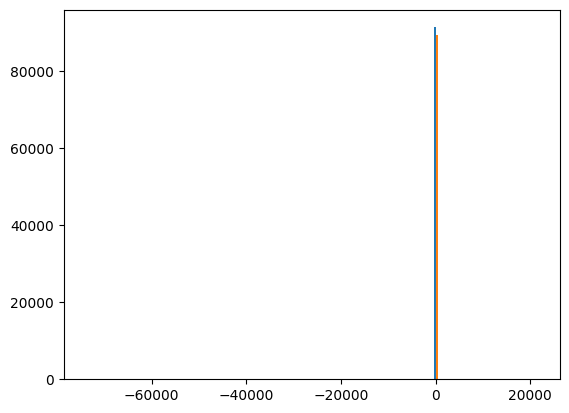

In [67]:
plt.hist(af_preds, bins=100)